# **1. Libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap #for XAI
import numpy as np
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#!pip install lime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
import nltk as nlp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from lime.lime_text import LimeTextExplainer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


# **2. Load dataset**

In [2]:
# Load the dataframes
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

# Add label columns
fake_df['label'] = 0
true_df['label'] = 1

# Combine dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the combined dataframe
df.head()


title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1

# **3. EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [4]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [5]:
#label distribution
df.label.value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

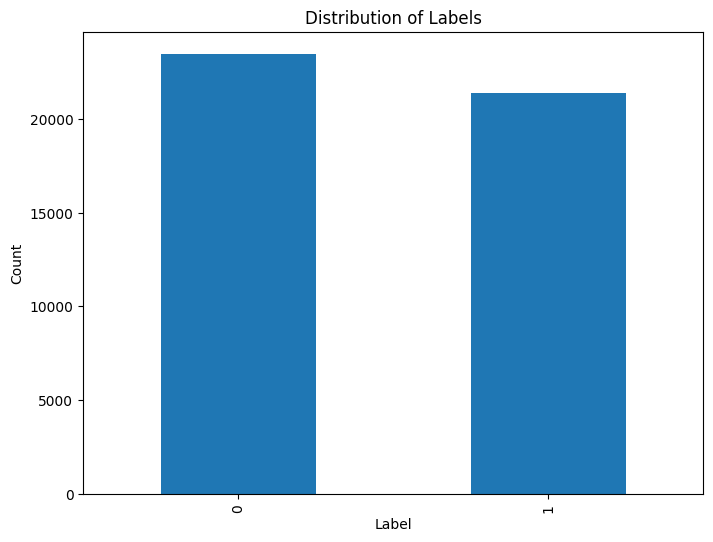

In [6]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

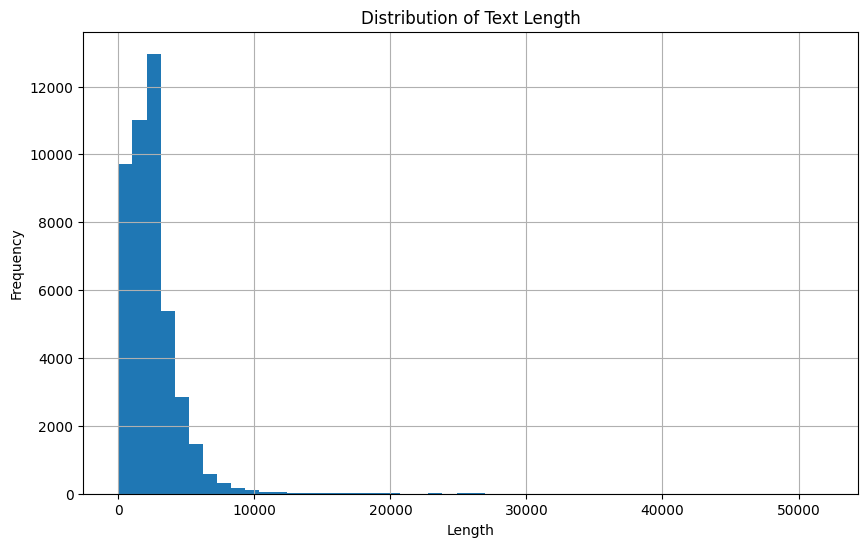

In [7]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
df['text_length'].hist(bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Note that most of the text lengths is between zero and ten thousand

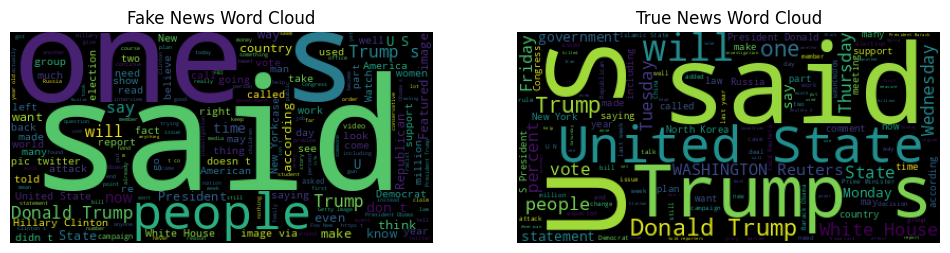

In [8]:
from wordcloud import WordCloud

fake_texts = df[df['label'] == 0]['text']
true_texts = df[df['label'] == 1]['text']

fake_text = ' '.join(fake_texts)
true_text = ' '.join(true_texts)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud().generate(fake_text))
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud().generate(true_text))
plt.title('True News Word Cloud')
plt.axis('off')

plt.show()


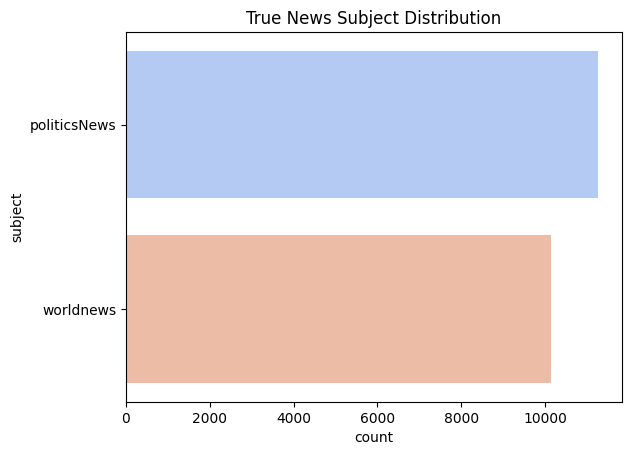

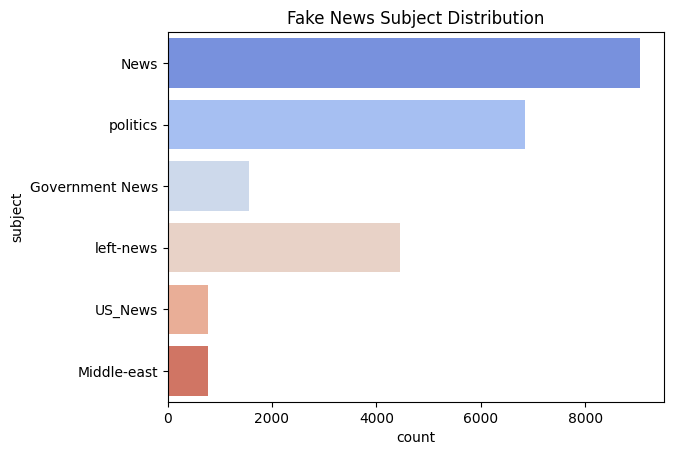

In [9]:


sns.countplot(y="subject", palette="coolwarm", data=true_df).set_title('True News Subject Distribution')
plt.show()

sns.countplot(y="subject", palette="coolwarm", data=fake_df).set_title('Fake News Subject Distribution')
plt.show()
     

# **4. Pre-processing**

In [10]:
print(df['text'])

0        21st Century Wire says Ben Stein, reputable pr...
1        WASHINGTON (Reuters) - U.S. President Donald T...
2        (Reuters) - Puerto Rico Governor Ricardo Rosse...
3        On Monday, Donald Trump once again embarrassed...
4        GLASGOW, Scotland (Reuters) - Most U.S. presid...
                               ...                        
44893                                                     
44894    LONDON/TOKYO (Reuters) - British Prime Ministe...
44895    BERLIN (Reuters) - Chancellor Angela Merkel sa...
44896    Jesus f*cking Christ our President* is a moron...
44897    IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...
Name: text, Length: 44898, dtype: object


In [11]:
#Function to process text
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [12]:
df["text"] = df["text"].apply(wordopt) #applying the preprocessing to the text column

In [13]:
print(df['text'])

0         century wire says ben stein  reputable profes...
1        washington  reuters    u s  president donald t...
2         reuters    puerto rico governor ricardo rosse...
3        on monday  donald trump once again embarrassed...
4        glasgow  scotland  reuters    most u s  presid...
                               ...                        
44893                                                     
44894    london tokyo  reuters    british prime ministe...
44895    berlin  reuters    chancellor angela merkel sa...
44896    jesus f cking christ our president  is a moron...
44897    if she s not toast now then we re in bigger tr...
Name: text, Length: 44898, dtype: object


Note that the test data has been preprocessed

In [14]:
# Combine 'title' and 'text' into a single feature
df["combined_text"] = df["title"] + " " + df["text"]

# Define Features and Labels
X = df["combined_text"]  # Single combined text column
y = df["label"]

# Step 4: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **5. Models**

## **5.1 RandomForest + XAI**

In [15]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('classifier',RandomForestClassifier(n_estimators=100,max_depth=10, min_samples_split=10))
])

#  Train the Model
pipeline.fit(X_train, y_train)

# Preprocess and Predict on the Test Data
y_pred_rf= pipeline.predict(X_test)


In [16]:
#  Evaluate model performance

# Calculate Training Accuracy
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.6f}")

# Calculate Testing accuracy
test_accuracy= accuracy_score(y_test, y_pred_rf)
print(f"Testing Accuracy: {test_accuracy:.6f}")

#calculating the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=['fake', 'true']))

Training Accuracy: 0.981163
Testing Accuracy: 0.971938
Classification Report:

              precision    recall  f1-score   support

        fake       0.97      0.97      0.97      7065
        true       0.97      0.97      0.97      6405

    accuracy                           0.97     13470
   macro avg       0.97      0.97      0.97     13470
weighted avg       0.97      0.97      0.97     13470



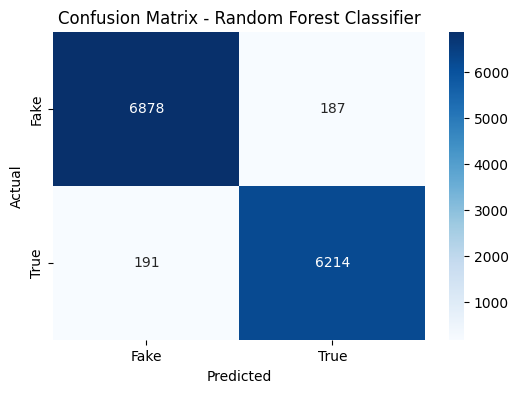

In [17]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

In [18]:
#  Use LIME for Explanation
explainer = LimeTextExplainer(class_names=['Fake', 'True'])

idx = 0 

# Explain the prediction for a specific document
exp = explainer.explain_instance(X_test.iloc[idx], pipeline.predict_proba, num_features=6)

# Display explanation in notebook
exp.show_in_notebook(text=True)


## **5.2 Support Vector Machine + XAI**

In [19]:
# Create a Pipeline for Text Preprocessing and Classification
from sklearn.feature_selection import SelectKBest, chi2

pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('feature_selection', SelectKBest(chi2, k=1000)),  # Adjust k as necessary
    ('classifier', SVC(kernel='linear', random_state=42, probability=True, gamma=0.1))
])

#  Train the Model
pipeline.fit(X_train, y_train)
# Preprocess and Predict on the Test Data
y_pred_svm = pipeline.predict(X_test)



In [20]:
# Calculate Training Accuracy
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.6f}")

# Calculate Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Testing Accuracy: {test_accuracy:.6f}")

#calculating the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_svm, target_names=['fake', 'true']))

Training Accuracy: 0.992618
Testing Accuracy: 0.989607
Classification Report:

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      7065
        true       0.99      0.99      0.99      6405

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



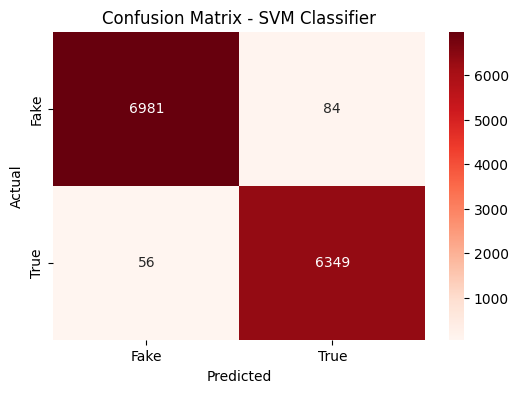

In [21]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM Classifier')
plt.show()

In [22]:
#  LIME for Explanation
explainer = LimeTextExplainer(class_names=['Fake', 'true'])

idx = 0 

# Explain the prediction for a specific document
exp = explainer.explain_instance(X_test.iloc[idx], pipeline.predict_proba, num_features=6)

# Display explanation in notebook
exp.show_in_notebook(text=True)


## **5.3 Logistic Regression + XAI**

In [23]:
# Create a Pipeline for Text Preprocessing and Classification
pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('classifier', LogisticRegression(random_state=42))  
])

#  Train the Model
pipeline.fit(X_train, y_train)

# Preprocess and Predict on the Test Data
y_pred_lg= pipeline.predict(X_test)



In [24]:
#  Evaluate model performance


# Calculate Training Accuracy
y_train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.6f}")

# Calculate Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_lg)
print(f"Testing Accuracy: {test_accuracy:.6f}")

#calculating the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_lg, target_names=['fake', 'true']))

Training Accuracy: 0.992173
Testing Accuracy: 0.985004
Classification Report:

              precision    recall  f1-score   support

        fake       0.99      0.98      0.99      7065
        true       0.98      0.99      0.98      6405

    accuracy                           0.99     13470
   macro avg       0.98      0.99      0.98     13470
weighted avg       0.99      0.99      0.99     13470



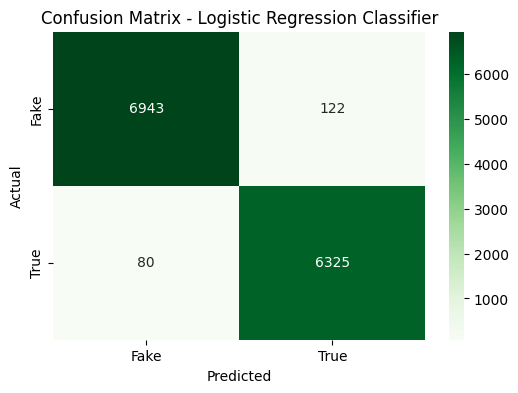

In [25]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lg)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression Classifier')
plt.show()

In [26]:
#  LIME for Explanation
explainer = LimeTextExplainer(class_names=['Fake', 'true'])

idx = 0 

# Explain the prediction for a specific document
exp = explainer.explain_instance(X_test.iloc[idx], pipeline.predict_proba, num_features=6)

# Display explanation in notebook
exp.show_in_notebook(text=True)


# **Comparison of testing accuracy**

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


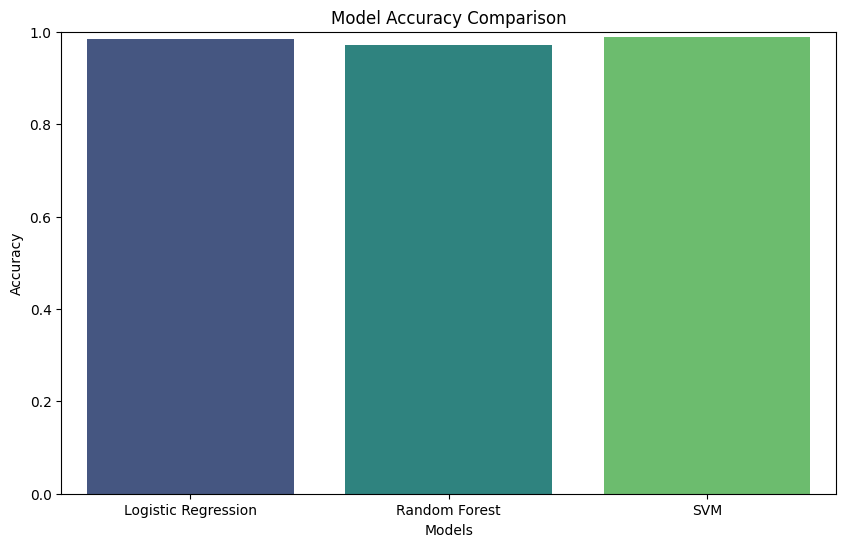

In [27]:
# Model Names and Accuracies
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_lg),
              accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_svm)]
# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()


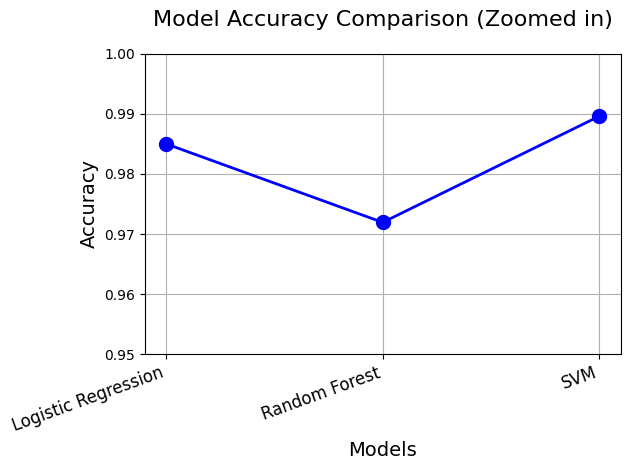

In [32]:
# Model Names and Accuracies
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_lg),
              accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_svm)]

# Create a line chart focusing on the accuracy range between 0.8 and 1
plt.figure()
plt.plot(models, accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=10)
plt.title('Model Accuracy Comparison (Zoomed in)', fontsize=16, pad=20)
plt.ylim(0.95, 1)  # Zoomed in to the range between 0.8 and 1
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.xticks(rotation=20, ha='right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
